In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://archive.apache.org/dist/spark/spark-2.4.0/spark-2.4.0-bin-hadoop2.7.tgz
!tar -xvf spark-2.4.0-bin-hadoop2.7.tgz
!pip install -q findspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.0-bin-hadoop2.7"
import findspark
findspark.init()

spark-2.4.0-bin-hadoop2.7/
spark-2.4.0-bin-hadoop2.7/python/
spark-2.4.0-bin-hadoop2.7/python/setup.cfg
spark-2.4.0-bin-hadoop2.7/python/pyspark/
spark-2.4.0-bin-hadoop2.7/python/pyspark/resultiterable.py
spark-2.4.0-bin-hadoop2.7/python/pyspark/python/
spark-2.4.0-bin-hadoop2.7/python/pyspark/python/pyspark/
spark-2.4.0-bin-hadoop2.7/python/pyspark/python/pyspark/shell.py
spark-2.4.0-bin-hadoop2.7/python/pyspark/heapq3.py
spark-2.4.0-bin-hadoop2.7/python/pyspark/join.py
spark-2.4.0-bin-hadoop2.7/python/pyspark/version.py
spark-2.4.0-bin-hadoop2.7/python/pyspark/rdd.py
spark-2.4.0-bin-hadoop2.7/python/pyspark/java_gateway.py
spark-2.4.0-bin-hadoop2.7/python/pyspark/find_spark_home.py
spark-2.4.0-bin-hadoop2.7/python/pyspark/_globals.py
spark-2.4.0-bin-hadoop2.7/python/pyspark/worker.py
spark-2.4.0-bin-hadoop2.7/python/pyspark/accumulators.py
spark-2.4.0-bin-hadoop2.7/python/pyspark/mllib/
spark-2.4.0-bin-hadoop2.7/python/pyspark/mllib/feature.py
spark-2.4.0-bin-hadoop2.7/python/pyspark

In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [3]:
%cd '/content/gdrive/My Drive/LDS9_K273_ONLINE_BuiThiHuong/LDS9_K273_BuiThiHuong_Cuoi_ky/'

/content/gdrive/My Drive/LDS9_K273_ONLINE_BuiThiHuong/LDS9_K273_BuiThiHuong_Cuoi_ky


In [4]:
import pyspark

In [5]:
from pyspark.sql import SparkSession

In [6]:
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.ml.feature import Tokenizer, RegexTokenizer
from pyspark.sql.types import IntegerType, StringType
from pyspark.ml.feature import StopWordsRemover
from pyspark.ml.feature import CountVectorizer
from pyspark.ml.feature import IDF, Tokenizer
from pyspark.ml.feature import NGram

from pyspark.ml.linalg import Vector
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler
from pyspark.ml.clustering import KMeans, LDA
from pyspark.ml import Pipeline, PipelineModel
from pyspark.ml.evaluation import ClusteringEvaluator

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import time


In [7]:
spark = SparkSession.builder.appName('C4_Clustering_Movies_Clustering').getOrCreate()

## Read data

In [8]:
start_time = time.time()

In [9]:
# Load data
## Note: each cell contains a dictionary. So we have to use escape option as "
data = spark.read.format('csv').\
                  option("delimiter", ",").\
                  option("header","true").\
                  option("quote", "\"").\
                  option('escape','"').\
                  option("multiLine", "true").\
                  option("inferSchema", "true").\
                  option("parserLib", "UNIVOCITY").\
                  option("ignoreTrailingWhiteSpace","true").\
                  option("ignoreLeadingWhiteSpace", "true").\
                  load('Data/tmdb_5000_movies.csv') 

In [10]:
data.show(2, truncate=False, vertical=True)

-RECORD 0-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 budget               | 237000000                                                                                                                                                                                                              

In [11]:
data.printSchema()

root
 |-- budget: integer (nullable = true)
 |-- genres: string (nullable = true)
 |-- homepage: string (nullable = true)
 |-- id: integer (nullable = true)
 |-- keywords: string (nullable = true)
 |-- original_language: string (nullable = true)
 |-- original_title: string (nullable = true)
 |-- overview: string (nullable = true)
 |-- popularity: double (nullable = true)
 |-- production_companies: string (nullable = true)
 |-- production_countries: string (nullable = true)
 |-- release_date: timestamp (nullable = true)
 |-- revenue: long (nullable = true)
 |-- runtime: double (nullable = true)
 |-- spoken_languages: string (nullable = true)
 |-- status: string (nullable = true)
 |-- tagline: string (nullable = true)
 |-- title: string (nullable = true)
 |-- vote_average: double (nullable = true)
 |-- vote_count: integer (nullable = true)



In [12]:
data.count()

4803

In [13]:
data.select('id').distinct().count()

4803

In [14]:
# convert "release_date" to StringType to check NaN
data = data.withColumn('release_date', col('release_date').cast(StringType()))

In [15]:
# check NaN
data.select([sum(when(isnan(col(col_name)),1)
          .otherwise(0)).alias(col_name)
          for col_name in data.columns]).toPandas().T

,0
budget,0
genres,0
homepage,0
id,0
keywords,0
original_language,0
original_title,0
overview,0
popularity,0
production_companies,0


In [16]:
# check null
data.select([sum(when(col(col_name).isNull(),1)
          .otherwise(0)).alias(col_name)
          for col_name in data.columns]).toPandas().T

,0
budget,0
genres,0
homepage,3091
id,0
keywords,0
original_language,0
original_title,0
overview,4
popularity,0
production_companies,0


In [17]:
# data = data.sample(0.01)

In [18]:
# data.filter(col('id')==25248).show()

## Data-Preprocessing

In [19]:
data.columns

['budget',
 'genres',
 'homepage',
 'id',
 'keywords',
 'original_language',
 'original_title',
 'overview',
 'popularity',
 'production_companies',
 'production_countries',
 'release_date',
 'revenue',
 'runtime',
 'spoken_languages',
 'status',
 'tagline',
 'title',
 'vote_average',
 'vote_count']

In [20]:
choosen_cols = ['id',
                'genres',
                'keywords',
                'overview',
                'popularity',
                'tagline',
                'title']
# choosen_cols = ['overview',
#                 'tagline',
#                 'title']

In [21]:
data = data.select(choosen_cols)

In [22]:
data = data.na.drop()

In [23]:
data.count()

3959

In [24]:
# create "combined_text" column
data = data.select("*", concat(col("title"), lit(". "), col("tagline"), lit(". "), col("overview")).alias("combined_text"))

In [25]:
# create "length" column
data = data.withColumn('length', length(data['combined_text']))

In [26]:
# change type of "popularity" column
data = data.withColumn('popularity', col('popularity').cast('float'))

In [27]:
data.show(2, truncate=False, vertical=True)

-RECORD 0------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 id            | 19995                                                                                                                                                                                                                                

In [28]:
# extract "name" from "genres" column
genres_data = data.select('id','genres')
genres_df = genres_data.withColumn('col', from_json("genres", ArrayType(StringType())))
genres_df = genres_df.withColumn('explode_col', explode("col"))
genres_df = genres_df.withColumn('col', from_json("explode_col", MapType(StringType(), StringType())))
genres_df = genres_df.withColumn("name", genres_df.col.getItem("name"))
# genres_df.select('genres','id','name').show(5, truncate=False)
genres_df2 = genres_df.groupBy('id').agg(collect_set('name').alias('genres_list'))
genres_df2.show(5,False)

+----+-------------------------+
|id  |genres_list              |
+----+-------------------------+
|496 |[Comedy]                 |
|1591|[Drama]                  |
|1645|[Thriller, Crime, Drama] |
|2122|[Thriller, Crime, Comedy]|
|2142|[Action, Crime, Drama]   |
+----+-------------------------+
only showing top 5 rows



In [29]:
genres_df2.count()

3956

In [30]:
# extract "name" from "keywords" column
keywords_data = data.select('id','keywords')
keywords_df = keywords_data.withColumn('col', from_json("keywords", ArrayType(StringType())))
keywords_df = keywords_df.withColumn('explode_col', explode("col"))
keywords_df = keywords_df.withColumn('col', from_json("explode_col", MapType(StringType(), StringType())))
keywords_df = keywords_df.withColumn("name", keywords_df.col.getItem("name"))
# keywords_df.select('keywords','id','name').show(5, truncate=False)
keywords_df2 = keywords_df.groupBy('id').agg(collect_set('name').alias('keywords_list'))
keywords_df2.show(5,False)

+----+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|id  |keywords_list                                                                                                                                                                                                                                               |
+----+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|496 |[rodeo, male nudity, prostitute, mockumentary, chicken, demeanor course, aftercreditsstinger, duringcreditsstinger, reporter, bear, anti semitism, usa, california, journalist, kazakhstan, driving school]           

In [31]:
keywords_df2.count()

3759

In [32]:
# join genres_df, keywords_df into data
data = data.join(genres_df2, on='id', how='leftouter').join(keywords_df2, on='id', how='leftouter')

In [33]:
data.show(3)

+------+--------------------+--------------------+--------------------+----------+--------------------+--------------------+--------------------+------+--------------------+--------------------+
|    id|              genres|            keywords|            overview|popularity|             tagline|               title|       combined_text|length|         genres_list|       keywords_list|
+------+--------------------+--------------------+--------------------+----------+--------------------+--------------------+--------------------+------+--------------------+--------------------+
| 19995|[{"id": 28, "name...|[{"id": 1463, "na...|In the 22nd centu...| 150.43758|Enter the World o...|              Avatar|Avatar. Enter the...|   212|[Action, Fantasy,...|[love affair, spa...|
|   285|[{"id": 12, "name...|[{"id": 270, "nam...|Captain Barbossa,...| 139.08261|At the end of the...|Pirates of the Ca...|Pirates of the Ca...|   266|[Fantasy, Action,...|[exotic island, f...|
|206647|[{"id": 28, "name

In [34]:
data.count()

3959

In [35]:
data.select('id','genres_list').filter(col('genres_list').isNull()).show(5, False)

+------+-----------+
|id    |genres_list|
+------+-----------+
|48382 |null       |
|198370|null       |
|126186|null       |
+------+-----------+



## Pipeline (for Feature Engineering)

In [36]:
# tokenizer
regexTokenizer1 = RegexTokenizer(inputCol='overview', outputCol='words1', pattern='\\W')
regexTokenizer2 = RegexTokenizer(inputCol='tagline', outputCol='words2', pattern='\\W')
regexTokenizer3 = RegexTokenizer(inputCol='title', outputCol='words3', pattern='\\W')
regexTokenizer = RegexTokenizer(inputCol='combined_text', outputCol='words', pattern='\\W')

# NGram
ngram = NGram(n=2, inputCol='words', outputCol='ngrams')

# stopwords
stopwords_additional = pd.read_csv('C4_stopwords_additional.txt', header=None)
stopwordList = list(set(stopwords_additional[0])) #additional stopwords
stopwordList = stopwordList + list(set(STOPWORDS)) #stopwords of pandas
stopwordList.extend(StopWordsRemover().getStopWords()) #stopwords of pyspark
stopwordList = list(set(stopwordList)) #optionnal

remover1 = StopWordsRemover(inputCol='words1', outputCol='filtered1', stopWords=stopwordList) #overview
remover2 = StopWordsRemover(inputCol='words2', outputCol='filtered2', stopWords=stopwordList) #tagline
remover3 = StopWordsRemover(inputCol='words3', outputCol='filtered3', stopWords=stopwordList) #title
remover = StopWordsRemover(inputCol='words', outputCol='filtered', stopWords=stopwordList) #combined_text
# remover = StopWordsRemover(inputCol='ngrams', outputCol='filtered', stopWords=stopwordList)

# CountVectorizer
cv1 = CountVectorizer(inputCol='filtered1', outputCol='features1', vocabSize=500, minDF=1) #overview
cv2 = CountVectorizer(inputCol='filtered2', outputCol='features2', vocabSize=500, minDF=1) #tagline
cv3 = CountVectorizer(inputCol='filtered3', outputCol='features3', vocabSize=500, minDF=1) #title
cv4 = CountVectorizer(inputCol='genres_list', outputCol='features4', vocabSize=6, minDF=1) #genres
cv5 = CountVectorizer(inputCol='keywords_list', outputCol='features5', vocabSize=60, minDF=1) #keywords
cv = CountVectorizer(inputCol='filtered', outputCol='features', vocabSize=500, minDF=1) #combined_text

# TF-IDF
idf1 = IDF(inputCol='features1', outputCol='tf_idf_features1') #overview
idf2 = IDF(inputCol='features2', outputCol='tf_idf_features2') #tagline
idf3 = IDF(inputCol='features3', outputCol='tf_idf_features3') #title
idf4 = IDF(inputCol='features4', outputCol='tf_idf_features4') #genres
idf5 = IDF(inputCol='features5', outputCol='tf_idf_features5') #keywords
idf = IDF(inputCol='features', outputCol='tf_idf_features') #combined_text

# VectorAssembler
assembler1 = VectorAssembler(inputCols=['tf_idf_features1', 'tf_idf_features2', 'tf_idf_features3','tf_idf_features4', 'tf_idf_features5'],
                            outputCol='vec_features') #overview, tagline, title, genres, keywords                           
assembler2 = VectorAssembler(inputCols=['tf_idf_features4', 'tf_idf_features5'],
                            outputCol='vec_features') #genres, keywords
assembler3 = VectorAssembler(inputCols=['tf_idf_features','popularity'],
                            outputCol='vec_features') #combined_text, popularity
assembler = VectorAssembler(inputCols=['tf_idf_features'], 
                            outputCol='vec_features') #combined_text

# Scaler
scaler = StandardScaler(inputCol='vec_features',
                        outputCol='scaledFeatures',
                        withStd=True,
                        withMean=False)

# # StringIndexer
# indexer = StringIndexer(inputCol='class',
#                         outputCol='label')

In [37]:
# pipeline_pre = Pipeline(stages=[regexTokenizer1,regexTokenizer2,regexTokenizer3,regexTokenizer,
#                                   ngram,
#                                   remover1,remover2,remover3,remover,                                   
#                                   cv1,cv2,cv3,cv,
#                                   idf1,idf2,idf3,idf,
#                                   assembler3,
#                                   scaler])  
pipeline_pre = Pipeline(stages=[regexTokenizer1,regexTokenizer2,regexTokenizer3,regexTokenizer,
                                  remover1,remover2,remover3,remover,                                   
                                  cv1,cv2,cv3,cv,
                                  idf1,idf2,idf3,idf,
                                  assembler3,
                                  scaler]) 

In [38]:
# fit and trainsform with pipeline model
pipeline_pre_model = pipeline_pre.fit(data)
final_data = pipeline_pre_model.transform(data)

In [39]:
# # create columns show number of tokens
countTokens = udf(lambda words: len(words), IntegerType())
# final_data = final_data.withColumn('genres_tokens', countTokens(col('genres_list')))
# final_data = final_data.withColumn('keywords_tokens', countTokens(col('keywords_list')))

In [40]:
# final_data.select('genres_tokens').agg({'genres_tokens':'max'}).show()

In [41]:
# final_data.select('keywords_tokens').agg({'keywords_tokens':'max'}).show()

In [42]:
# create columns show number of tokens
final_data = final_data.withColumn('tokens', countTokens(col('words')))

In [43]:
final_data.show(3)

+------+--------------------+--------------------+--------------------+----------+--------------------+--------------------+--------------------+------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------+
|    id|              genres|            keywords|            overview|popularity|             tagline|               title|       combined_text|length|         genres_list|       keywords_list|              words1|              words2|              words3|               words|           filtered1|           filtered2|           filtered3|            filtered|           features1|           features2|           featu

In [44]:
final_data.count()

3959

## TEST

In [45]:
# stopwords_additional = pd.read_csv('C4_stopwords_additional.txt', header=None)
# stopwords_additional

In [46]:
a = regexTokenizer.transform(data)

In [47]:
a = ngram.transform(a)

In [48]:
a = remover.transform(a)

In [49]:
a.show(5,False)

+------+--------------------------------------------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------------------------------------------------------------------------------------------

In [50]:
# cv5_model = cv5.fit(a)

## Select k

In [51]:
# trains a k-means model
k_list = []
wsse_list = []
silhouette_list = []

wsse_str= ""
sil_str = ""

for k in range(2,11):
  k_list.append(k)
  kmeans = KMeans(featuresCol='scaledFeatures', maxIter=500, initSteps=1, seed=1, k=k)    
  kmeans_model = kmeans.fit(final_data)
  # wsse
  wsse = kmeans_model.computeCost(final_data)

  wsse_list.append(wsse) 

  # silhoutte
  predictions = kmeans_model.transform(final_data)
  # Evaluate clustering by computing Silhouette score
  evaluator = ClusteringEvaluator(featuresCol='vec_features')
  silhouette = evaluator.evaluate(predictions)
  silhouette_list.append(silhouette)

  wsse_str = wsse_str + "With k =" + str(k) + "- Set Sum of Squared Errors = " + str(wsse) + "\n"
  sil_str = sil_str + "With k =" + str(k) + "- Silhouette = " + str(silhouette) + "\n"

In [52]:
# # trains a k-means model with cross validation
# k_list = []
# wsse_means = []
# silhouette_means = []

# wsse_str= ""
# sil_str = ""

# for k in range(2,11):
#   k_list.append(k)
#   wsse_list = []
#   silhouette_list = []
#   for n in range(1,6):
#     pipeline_pre_model = pipeline_pre.fit(data)
#     final_data = pipeline_pre_model.transform(data)
#     kmeans = KMeans(featuresCol='scaledFeatures', k=k)    
#     kmeans_model = kmeans.fit(final_data)
#     # wsse
#     wsse = kmeans_model.computeCost(final_data)
#     wsse_list.append(wsse) 

#     # silhoutte
#     predictions = kmeans_model.transform(final_data)
#     # Evaluate clustering by computing Silhouette score
#     evaluator = ClusteringEvaluator(featuresCol='vec_features')
#     silhouette = evaluator.evaluate(predictions)
#     silhouette_list.append(silhouette)

#     # wsse_str = wsse_str + "With k =" + str(k) + "- Set Sum of Squared Errors = " + str(wsse) + "\n"
#     # sil_str = sil_str + "With k =" + str(k) + "- Silhouette = " + str(silhouette) + "\n"
#   print('k=',k)
#   print('wsse:',wsse_list)
#   print('sil:',silhouette_list)
#   wsse_means.append(np.mean(wsse_list))
#   silhouette_means.append(np.mean(silhouette_list))

In [53]:
# wsse_means

In [54]:
# silhouette_means

In [55]:
# print(wsse_str)

In [56]:
# sil_str

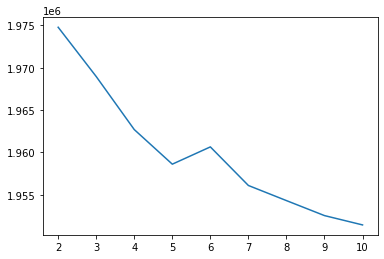

In [57]:
# plot wsse_list
plt.plot(k_list, wsse_list)
plt.show()

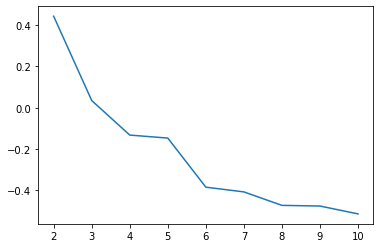

In [58]:
# plot silhoutte_list
plt.plot(k_list, silhouette_list)
plt.show()

According to the Elbow curve, choose k=5. Because with k>=5, WSSE is not much lower.

## Build Kmeans model

In [59]:
# create Kmeans model
kmeans = KMeans(featuresCol='scaledFeatures', maxIter=500, initSteps=1, seed=1, k=5)   
#=> maxIter=500 (high), seed=1 (instead of 'random') to help the model stable when change centroids

kmeans_model = kmeans.fit(final_data)

In [60]:
# fit model with final_data
predictions_kmeans = kmeans_model.transform(final_data)

In [61]:
predictions_kmeans.groupBy('prediction').count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|         1|  511|
|         3|  806|
|         4|   34|
|         2|  364|
|         0| 2244|
+----------+-----+



In [62]:
# evaluate clustering by computing within set sum of squared errors
wsse = kmeans_model.computeCost(final_data)
print('WSSE:')
print(wsse)

WSSE:
1958618.539693843


In [63]:
# silhouette
predictions_kmeans = kmeans_model.transform(final_data)
# evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator()
silhouette = evaluator.evaluate(predictions)
print('Silhoutte:')
print(silhouette)

Silhoutte:
0.05146227157277051


In [64]:
# # show the result
# centers = kmeans_model.clusterCenters()
# print('Centers:')
# for center in centers:
#   print(center)

## Build LDA model (test)

In [65]:
# lda = LDA(k=6, maxIter=500, initSteps=1, seed=1, featuresCol='scaledFeatures')

In [66]:
# lda_model = lda.fit(final_data)

In [67]:
# ll = lda_model.logLikelihood(final_data)
# lp = lda_model.logPerplexity(final_data)
# print("The lower bound on the log likelihood of the entire corpus: " + str(ll))
# print("The upper bound on perplexity: " + str(lp))

In [68]:
# # Describe topics.
# topics = lda_model.describeTopics(3)
# print("The topics described by their top-weighted terms:")
# topics.show(truncate=False)

In [69]:
# # Shows the result
# predictions_lda = lda_model.transform(final_data)
# predictions_lda.show(3)

## Pipeline (for end to end)

In [70]:
# create pipeline end to end
pipeline_kmeans = Pipeline(stages=[regexTokenizer1,regexTokenizer2,regexTokenizer3,regexTokenizer,
                                  remover1,remover2,remover3,remover,                                   
                                  cv1,cv2,cv3,cv,
                                  idf1,idf2,idf3,idf,
                                  assembler3,
                                  scaler,
                                  kmeans])   

In [71]:
# fit pipeline model with data
pipeline_kmeans_model = pipeline_kmeans.fit(data)

In [72]:
predictions_2 = pipeline_kmeans_model.transform(data)

In [73]:
predictions_2.groupBy('prediction').count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|         1|  511|
|         3|  806|
|         4|   34|
|         2|  364|
|         0| 2244|
+----------+-----+



In [74]:
# evaluate clustering by computing within set sum of squared errors
final_data = pipeline_pre_model.transform(data)
wsse = pipeline_kmeans_model.stages[-1].computeCost(final_data)
print('WSSE:')
print(wsse)

WSSE:
1958618.539693843


## WordCloud

In [75]:
# show examples of each class
predictions_2.select('title','overview','prediction').filter(col('prediction')==0).show(5, truncate=False)

+------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|title                                     |overview                                                                                                                                                                                                                                                                  |prediction|
+------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|Avatar                        

In [76]:
predictions_2.select('title','overview','prediction').filter(col('prediction')==1).show(5, truncate=False)

+----------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|title                             |overview                                                                                                                                                                                                                                                                                                                                                                                                           

In [77]:
predictions_2.select('title','overview','prediction').filter(col('prediction')==2).show(5, truncate=False)

+----------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|title                                   |overview                                                                                                                                                                                                                                                                                                                                                                                                  |prediction|
+----------------------------------------+------------------------------------------------------------

In [78]:
predictions_2.select('title','overview','prediction').filter(col('prediction')==3).show(5, truncate=False)

+------------------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|title                   |overview                                                                                                                                                                                                      

In [79]:
predictions_2.select('title','overview','prediction').filter(col('prediction')==4).show(5, truncate=False)

+-----------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|title                              |overview                                                                                                                                                                                                                                                                                                                                        

In [81]:
# convert to Pandas DataFrame
predictions_pdf = predictions_2.toPandas()

class: 0


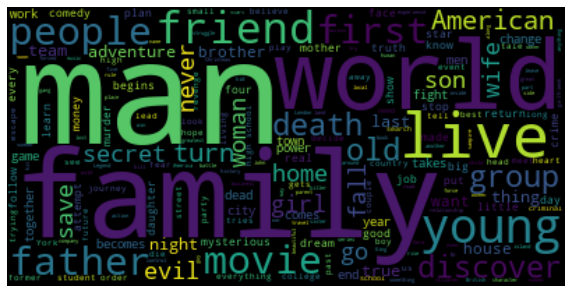

class: 1


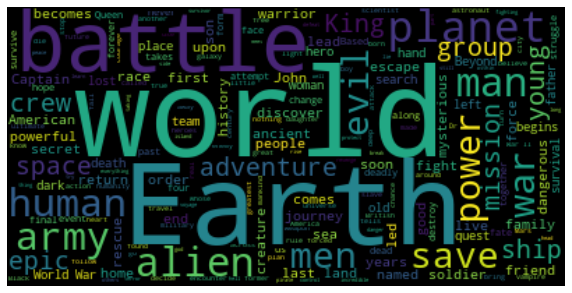

class: 2


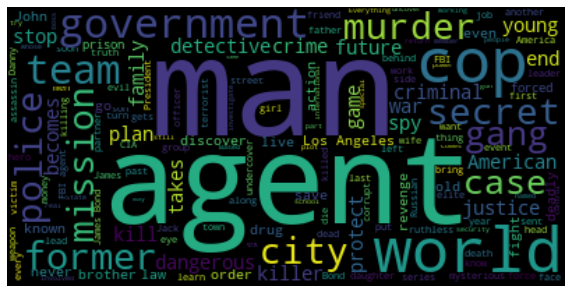

class: 3


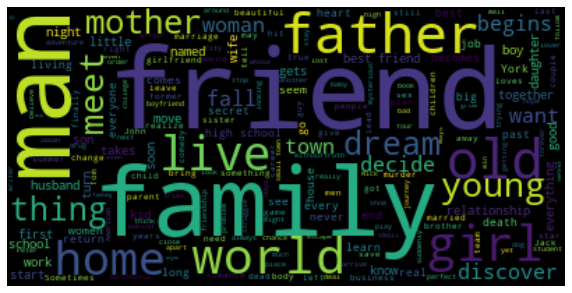

class: 4


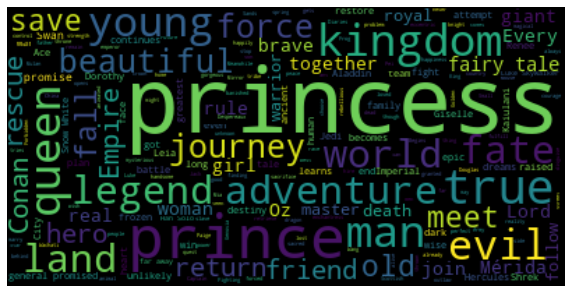

In [82]:
# WordCloud chart of each class
n = 0
y = predictions_pdf['prediction']
X = predictions_pdf[['combined_text']]
for i in y.sort_values().unique():
    # Tạo text
    text = ""
    for j in X.iloc[y[y==y.unique()[n]].index].iloc[:,0]:
        text = text + " " + j
    # Bieu do WordCloud
    plt.figure(figsize=(10,10))
    wc_text=WordCloud(stopwords = stopwordList)
    wc_text.generate(text)
    print('class:',i)
    plt.imshow(wc_text,interpolation="bilinear")
    plt.axis("off")
    plt.show()
    n=n+1

## Explain the chracteristics of each classes

1. Class 0: Movies with content related to:
    - The main character is usually male
    - Content coverage covers the whole world
    - Promote friendship, life, family, youth
2. Class 1: Movies with content related to:
    - The main character is usually male
    - Content coverage covers the entire world, the earth, or even the planets
    - Battles between the good side and the evil side
    - Adventures, missions
3. Class 2: Movies with content related to:
    - The main character is usually male
    - Content coverage covers the whole world
    - Social issues, murder, politics, police
4. Class 3: Movies with content related to:
    - The main character has both male and female characters
    - Emphasize friendship, family
5. Class 4: Movies with content related to:
    - The characters are princess, prince
    - Legends
    - Royal

## Save model

In [83]:
# save model
pipeline_kmeans_model.write().overwrite().save('C4_Clustering_pipeline_kmeans_MoviesClustering')

## Prediction

In [84]:
# load model from
pipeline_kmeans_model_1 = PipelineModel.load('C4_Clustering_pipeline_kmeans_MoviesClustering')

In [85]:
# predict with built model and data
predictions_2 = pipeline_kmeans_model_1.transform(data)

In [86]:
predictions_2.groupBy('prediction').count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|         1|  511|
|         3|  806|
|         4|   34|
|         2|  364|
|         0| 2244|
+----------+-----+



In [87]:
predictions_2.show(5,False)

+------+--------------------------------------------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------------------------------------------------------------------------------------------

In [88]:
end_time = time.time()

In [89]:
duration = (end_time - start_time)/60
duration

4.844426004091899